<div class="alert alert-success">
    <h2 align='center'>📔 Загрузим, Импортирум, и приготовим данные 👨🏻‍🍳</h2>
</div>

In [ ]:
%%sh
pip install -q timm
pip install -q einops
pip install -q rich
pip install -q wandb --upgrade;

In [2]:
import os
import sys
import re
import gc
import platform
import random

import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

import einops

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, train_test_split

import timm
import glob
import cv2

from rich import print as _pprint
from rich.progress import track

import albumentations as A
from albumentations.pytorch import ToTensorV2

import wandb

import warnings
warnings.simplefilter('ignore')

<div class="alert alert-success">
    <h2 align='center'>⛽ Utility Functions </h2>
</div>

In [3]:
def get_patient_id(patient_id):
    if patient_id < 10:
        return '0000'+str(patient_id)
    elif patient_id >= 10 and patient_id < 100:
        return '000'+str(patient_id)
    elif patient_id >= 100 and patient_id < 1000:
        return '00'+str(patient_id)
    else:
        return '0'+str(patient_id)

def get_path(row):
    patient_id = get_patient_id(row.BraTS21ID)
    return f'../input/rsna-miccai-png/train/{patient_id}/FLAIR/'

def wandb_log(**kwargs):
    """
    Logs a key-value pair to W&B
    """
    for k, v in kwargs.items():
        wandb.log({k: v})
        
def cprint(string):
    """
    Utility function for beautiful colored printing.
    """
    _pprint(f"[black]{string}[/black]")

<div class="alert alert-success">
    <h2 align='center'>🚀 Config Dictionary and W&B Integration </h2>
</div>

In [5]:
Config = dict(
    MAX_FRAMES = 12,
    EPOCHS = 5,
    LR = 2e-4,
    IMG_SIZE = (224, 224),
    FEATURE_EXTRACTOR = 'resnext50_32x4d',
    DR_RATE = 0.35,
    NUM_CLASSES = 12,
    RNN_HIDDEN_SIZE = 256,
    RNN_LAYERS = 2,
    TRAIN_BS = 10,
    VALID_BS = 10,
    NUM_WORKERS = 4,
    
    _wandb_kernel = 'tanaym'
)

To login to W&B, you can use below snippet.

```python
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wb_key = user_secrets.get_secret("WANDB_API_KEY")

wandb.login(key=wb_key)
```
Make sure you have your W&B key stored as `WANDB_API_KEY` under Add-ons -> Secrets

You can view [this](https://www.kaggle.com/ayuraj/experiment-tracking-with-weights-and-biases) notebook to learn more about W&B tracking.

If you don't want to login to W&B, the kernel will still work and log everything to W&B in anonymous mode.

In [6]:
run = wandb.init(
    project='pytorch',
    config=Config,
    job_type='train',
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: alexwortega. Use `wandb login --relogin` to force relogin


In [7]:
import io
import os
import PIL
import random
import numpy as np
import torch
import torchvision
import more_itertools
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from torch.utils.data import Dataset
from tqdm import tqdm
from dataclasses import dataclass, field
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import cv2
from PIL import Image
import pickle
from tqdm.contrib import tzip
from tqdm.notebook import tqdm
class Augments:
    """
    Contains Train, Validation Augments
    """
    train_augments = A.Compose([
        ToTensorV2(p=1.0),
    ],p=1.)
    
    valid_augments = A.Compose([
        ToTensorV2(p=1.0),
    ], p=1.)


def read_video(path, transform=None, frames_num=6):
    frames = []
    cap = cv2.VideoCapture(path)
    
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    N = length//(frames_num)
   
    
    current_frame = 1
    for i in range(length):
        ret, frame = cap.read(current_frame)
        
        if ret and i==current_frame and len(frames)<frames_num:
           
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, Config['IMG_SIZE'])
            
            frames.append(frame)
            current_frame += N
        
    cap.release()
    #print(frames)
    return frames

<div class="alert alert-success">
    <h2 align='center'>💻 Custom Dataset Class</h2>
</div>

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 In this custom Dataset, I am essentially reading "MAX_FRAMES" number of images from a patient's FLAIR folder and making list of those frames and converting it to torch tensor.
</div>

In [8]:
df = pd.read_csv('train.csv')

In [10]:
df.head()

,Unnamed: 0,path,labels
0,578,France Argentiere church and cross with Alps_p...,cloud
1,229,Georgia Okefenokee reflections in scummy water...,water
2,544,170728_Berlin_A_012_preview.mp4,sunset
3,369,170209D_039_Diving_1080p_preview.mp4,water
4,442,motionplaces flower-Oct2018_preview.mp4,flower


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.path, df.labels, test_size=0.2, random_state=4242)
df_train = pd.DataFrame({'path':X_train, 'labels':y_train})
df_test = pd.DataFrame({'path':X_test, 'labels':y_test})
df_train.to_csv('train.csv')
df_test.to_csv('test.csv')

In [12]:
df_train = pd.read_csv('train.csv')
df_train.head()

,Unnamed: 0,path,labels
0,440,_import_6128976f7320b3.79014040_preview.mp4,car
1,11,000939521-ecuador-crater-lake-view_preview.mp4,water
2,484,170804_A_Lombok_026_preview.mp4,water
3,323,SunsetOverPortsmouthHarbourVidevo_preview.mp4,sunset
4,472,Limousin_Cows_1__VIdevo_preview.mp4,animal


<AxesSubplot:>

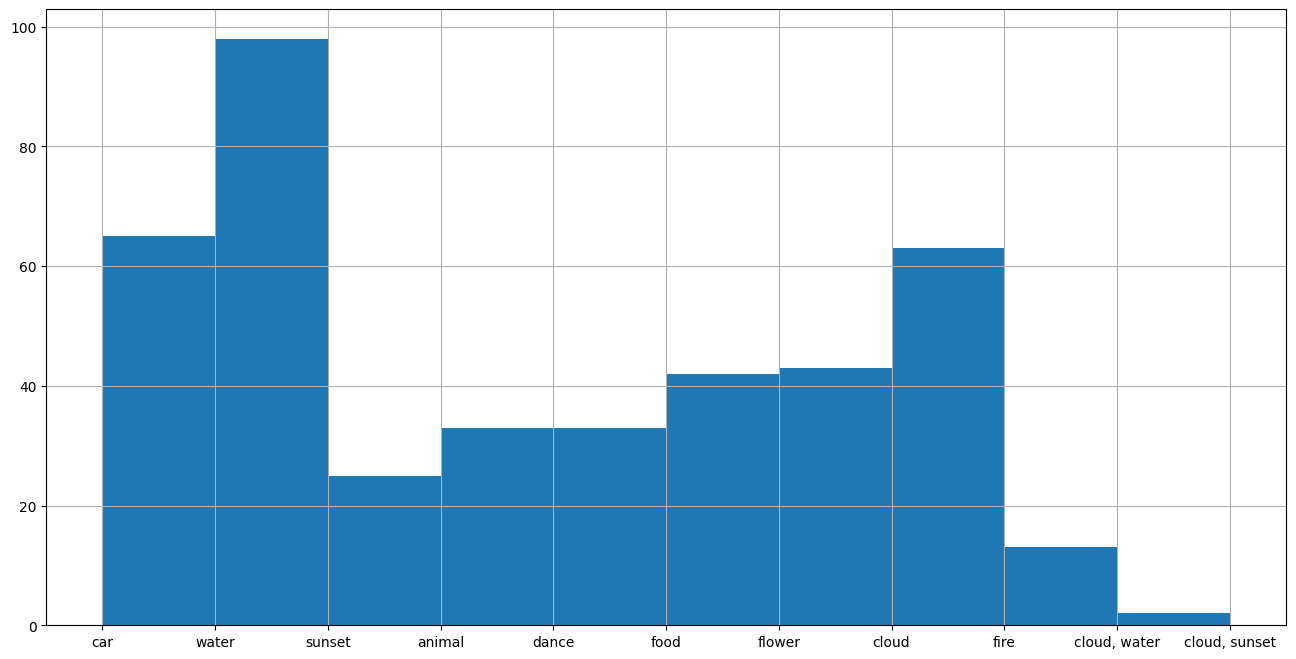

In [13]:
df_train.labels.hist(figsize=(16,8))

In [14]:
df_train.labels.value_counts()

water            98
car              65
cloud            63
flower           43
food             42
animal           33
dance            33
sunset           25
fire             13
cloud, water      1
cloud, sunset     1
Name: labels, dtype: int64

In [15]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
class RSNADataset(Dataset):
    def __init__(self, df,  is_test=False):
        self.df = df
        self.transform = A.Compose([
            ToTensorV2(p=1.0),
        ],p=1.)
        
        self.is_test = is_test
        self.samples = []
        self.cls = {'water':0,'car':1,'cloud':2,'food':3,'flower':4,'dance':5,'animal':6,'sunset':7,'fire':8,'cloud, sunset':2,'water, flower':0,'cloud, water':2}
        
        for path, label in tzip(df.path, df.labels):
          frames = read_video(f'video/{path}',Config['MAX_FRAMES'])
          self.samples +=[{'label': self.cls[str(label)],'frames': frames}]

        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        frames = sample['frames']


        frames_tr = torch.from_numpy(np.stack(frames, axis=2)).permute(2, 3, 0, 1)
            
        if self.is_test:
            return frames_tr
        else:
            label = torch.tensor(sample['label']).long()
            return frames_tr, label

<div class="alert alert-success">
    <h2 align='center'>📈 Model Class with ResNext Backbone</h2>
</div>

In [16]:
class ResNextModel(nn.Module):
    def __init__(self):
        super(ResNextModel, self).__init__()
        self.backbone = timm.create_model(Config['FEATURE_EXTRACTOR'], pretrained=True)
    def forward(self, x):
        return self.backbone(x)

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

class RSNAModel(nn.Module):
    def __init__(self, pretrained=True):
        super(RSNAModel, self).__init__()
        self.backbone = ResNextModel()
        for param in self.backbone.parameters():
            param.requires_grad = False
        self.num_features = self.backbone.backbone.fc.in_features
        
        self.backbone.backbone.fc = Identity()
        self.dropout= nn.Dropout(Config['DR_RATE'])
        self.rnn = nn.LSTM(self.num_features, Config['RNN_HIDDEN_SIZE'], Config['RNN_LAYERS'], dropout=0.1, batch_first=True, bidirectional=True )#bidirectional=True
        self.fc1 = nn.Linear(Config['RNN_HIDDEN_SIZE'] * 2, Config['NUM_CLASSES'])
        
    def forward(self, x):
        b, f, c, h, w = x.shape
        #print(x.reshape(b * f, c, h, w).shape)
        x = self.backbone(x.reshape(b * f, c, h, w))
        #print(x.shape)
        x = x.reshape(b, f, self.num_features)
        #print(x.shape)
        x, _ = self.rnn(x)
        #print(x.shape)
        x = self.dropout(x[:, -1])#
        #print(x.shape, self.num_features)
        x = self.fc1(x)
        return x

<div class="alert alert-success">
    <h2 align='center'>🏴‍☠️ Training and Validation Functions</h2>
</div>

In [17]:
def train_one_epoch(model, train_dataloader, optimizer, loss_fn, epoch, device, log_wandb=True, verbose=False):
    """
    Trains model for one epoch
    """
    model.train()
    running_loss = 0
    prog_bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
    for batch, (frames, targets) in prog_bar:
        optimizer.zero_grad()
        
        frames = frames.to(device, torch.float)
        targets = targets.to(device)
        
        # Re arrange the frames in the format our model wants to recieve
        preds = model(frames)
        loss = loss_fn(preds, targets)
        
        loss.backward()
        optimizer.step()
        
        loss_item = loss.item()
        running_loss += loss_item
        
        prog_bar.set_description(f"loss: {loss_item:.4f}")
        
        if log_wandb == True:
            wandb_log(
                batch_train_loss=loss_item
            )
        
        if verbose == True and batch % 20 == 0:
            print(f"Batch: {batch}, Loss: {loss_item}")
    
    avg_loss = running_loss / len(train_dataloader)
    
    return avg_loss

# w1 = W0 - grad*lr

@torch.no_grad()
def valid_one_epoch(model, valid_dataloader, loss_fn, epoch, device, log_wandb=True, verbose=False):
    """
    Validates the model for one epoch
    """
    model.eval()
    running_loss = 0
    prog_bar = tqdm(enumerate(valid_dataloader), total=len(valid_dataloader))
    for batch, (frames, targets) in prog_bar:
        frames = frames.to(device, torch.float)
        targets = targets.to(device)
        
        # Re arrange the frames in the format our model wants to recieve
        preds = model(frames)
        loss = loss_fn(preds, targets)
        
        loss_item = loss.item()
        running_loss += loss_item
        
        prog_bar.set_description(f"val_loss: {loss_item:.4f}")
        
        if log_wandb == True:
            wandb_log(
                batch_val_loss=loss_item
            )
        
        if verbose == True and batch % 10 == 0:
            print(f"Batch: {batch}, Loss: {loss_item}")
    
    avg_val_loss = running_loss / len(valid_dataloader)
    
    return avg_val_loss

<div class="alert alert-success">
    <h2 align='center'>🏗 Training and Validating the Model</h2>
</div>

In [18]:
log_wandb = True
if torch.cuda.is_available():
        print("Using GPU: {}\n".format(torch.cuda.get_device_name()))
        device = torch.device('cuda')
else:
        print("\nGPU not found. Using CPU: {}\n".format(platform.processor()))
        device = torch.device('cpu')
    
train_df = pd.read_csv('train.csv')
valid_df = pd.read_csv('test.csv')
    
print(f'Size of Training Set: {len(train_df)}, Validation Set: {len(valid_df)}')
    
    

Using GPU: Tesla V100-SXM2-32GB

Size of Training Set: 417, Validation Set: 105


In [19]:
train_data = RSNADataset(train_df)
valid_data = RSNADataset(valid_df)
train_loader = DataLoader(
        train_data,
        batch_size=Config['TRAIN_BS'], 
        shuffle=True,
        num_workers=Config['NUM_WORKERS']
)

valid_loader = DataLoader(
        valid_data, 
        batch_size=Config['VALID_BS'], 
        shuffle=False,
        num_workers=Config['NUM_WORKERS']
)

  0%|          | 0/417 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

In [20]:
model = RSNAModel()
model = model.to(device)
model.train()
optimizer = torch.optim.AdamW(model.parameters(), lr=Config['LR'])

train_loss_fn = nn.CrossEntropyLoss()
valid_loss_fn = nn.CrossEntropyLoss()
    
print(f"\nUsing Backbone: {Config['FEATURE_EXTRACTOR']}")

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnext50_32x4d_a1h-0146ab0a.pth" to /home/alexw/.cache/torch/hub/checkpoints/resnext50_32x4d_a1h-0146ab0a.pth



Using Backbone: resnext50_32x4d


In [21]:
current_loss = 1000
for epoch in range(Config['EPOCHS']):
    print(f"\n{'--'*8} EPOCH: {epoch+1} {'--'*8}\n")
        
    train_loss = train_one_epoch(model, train_loader, optimizer, train_loss_fn, epoch=epoch, device=device, log_wandb=log_wandb)
        
    valid_loss = valid_one_epoch(model, valid_loader, valid_loss_fn, epoch=epoch, device=device, log_wandb=log_wandb)
        
    print(f"val_loss: {valid_loss:.4f}")
        
    if log_wandb == True:
        wandb_log(
                train_loss=train_loss,
                valid_loss=valid_loss
        )
        
    if valid_loss < current_loss:
        current_loss = valid_loss
        torch.save(model.state_dict(), f"model_{Config['FEATURE_EXTRACTOR']}.pt")


---------------- EPOCH: 1 ----------------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

val_loss: 2.0826

---------------- EPOCH: 2 ----------------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

val_loss: 1.8311

---------------- EPOCH: 3 ----------------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

val_loss: 1.4732

---------------- EPOCH: 4 ----------------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

val_loss: 1.2765

---------------- EPOCH: 5 ----------------



  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

val_loss: 1.1808


In [22]:
gt = []
pred = []
model.eval()
prog_bar = tqdm(enumerate(valid_loader), total=len(valid_loader))
for batch, (frames, targets) in prog_bar:
    frames = frames.to('cuda').float()
    gt +=  list(targets.numpy())
    with torch.no_grad():

        pred += list(model(frames).argmax(dim=-1).to('cpu').flatten().numpy())


  0%|          | 0/11 [00:00<?, ?it/s]

In [29]:
torch.save(model.state_dict(),'sample_model.pt')

In [23]:
from sklearn.metrics import accuracy_score, f1_score #не замороженное
print(accuracy_score(gt, pred), f1_score(gt, pred, average='weighted'))

0.6095238095238096 0.5891808008978416


In [24]:
from sklearn.metrics import accuracy_score, f1_score #не замороженное
print(accuracy_score(gt, pred), f1_score(gt, pred, average='weighted'))

0.6095238095238096 0.5891808008978416


In [25]:
from sklearn.metrics import accuracy_score, f1_score #не замороженное
print(accuracy_score(gt, pred), f1_score(gt, pred, average='weighted'))

0.6095238095238096 0.5891808008978416


In [26]:
from sklearn.metrics import accuracy_score
print(accuracy_score(gt, pred))

0.6095238095238096


In [27]:
from sklearn.metrics import accuracy_score
print(accuracy_score(gt, pred))

0.6095238095238096


In [28]:
from sklearn.metrics import accuracy_score
print(accuracy_score(gt, pred))

0.6095238095238096
